## Problem Statement. 

Suppose you have data about the daily number of visitors of some restaurant. See test_restaurant.csv. Research the provided dataset, and create a forecast model for 1 day forward.


## Step1: Conduct Exploratory Analysis

- After importing the data, I looked at the fluctuation of the daily number of visitors and found that there is a consistent yearly pattern. This finding gives me some idea about what kind of variables I want to create later.

- I remove data with negative number of visitors. I assumed that they are labeled incorrectly.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

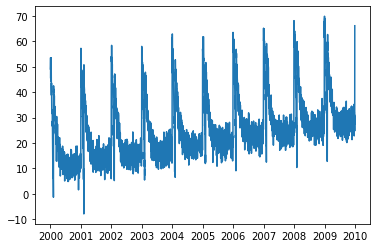

In [3]:
register_matplotlib_converters()
restaurant=pd.read_csv('test_restaurant.csv')
restaurant['date']=pd.to_datetime(restaurant['date'])
plt.plot(restaurant['date'],restaurant['num_visitors'])

In [4]:
restaurant.describe()

,num_visitors
count,3651.000000
mean,24.782759
std,11.188746
min,-7.867497
25%,17.042217
50%,22.950304
75%,29.260646
max,69.849130


In [5]:
data=restaurant.copy()
data=restaurant[restaurant['num_visitors']>=0]
data.describe()

,num_visitors
count,3649.000000
mean,24.798853
std,11.170399
min,0.181759
25%,17.052917
50%,22.961277
75%,29.262848
max,69.849130


## Step2: Feature engineering

15 variables created:

#### 1. Using 'date'to create 'day', 'month', and 'year', and perform target encoding (3 vars): 

since there are obvious annual and monthly pattern observed, I create new variables 'day', 'month', and 'year'. I did not do one-hot encoding because that will increase a lot of dimensionality. Instead, I performed target encoding. That is, I group by the same entity and replace the value with the average of y of that entity. For example, I replace "month: 1" with the average of num_visitors of all observations with the month variable being 1.

#### 2. Using sliding time window(n day) to calculate the avg, max, and min of the past n days (12 vars): 

- time window used: 3,7,14,30

- measurements used: avg, max, min

so 4 time windows * 3 measurement = 12 varaibles

In [7]:
data.loc[:,'day']=data.loc[:,'date'].apply(lambda x:x.weekday())
data.loc[:,'month']=data.loc[:,'date'].apply(lambda x:x.month)
data.loc[:,'year']=data.loc[:,'date'].apply(lambda x:x.year)
data.head(1)

,date,num_visitors,day,month,year
0,2000-01-01,49.12849,5,1,2000


In [8]:
### transforming "day"
TE_day=data.groupby('day')['num_visitors'].mean()

TE_dict={}
for i in range(len(TE_day)):
    TE_dict[TE_day.index[i]]=TE_day.values[i]

data.loc[:,'TE_day']=data['day'].map(TE_dict)

### transforming "month"
TE_month=data.groupby('month')['num_visitors'].mean()

TE_dict={}
for i in range(len(TE_month)):
    TE_dict[TE_month.index[i]]=TE_month.values[i]

data.loc[:,'TE_month']=data['month'].map(TE_dict)


### transforming "year"
TE_year=data.groupby('year')['num_visitors'].mean()

TE_dict={}
for i in range(len(TE_year)):
    TE_dict[TE_year.index[i]]=TE_year.values[i]

data.loc[:,'TE_year']=data['year'].map(TE_dict)

data.head(1)

,date,num_visitors,day,month,year,TE_day,TE_month,TE_year
0,2000-01-01,49.12849,5,1,2000,24.641221,41.713472,16.510188


In [10]:
avg_dic={'past_3D_AVG':3,'past_7D_AVG':7,'past_14D_AVG':14,'past_30D_AVG':30}
for k,v in avg_dic.items():
    for day in range(data.shape[0]-v):
        data.loc[day+v,k]=data.loc[day:day+v-1,'num_visitors'].mean()

max_dic={'past_3D_MAX':3,'past_7D_MAX':7,'past_14D_MAX':14,'past_30D_MAX':30}
for k,v in max_dic.items():
    for day in range(data.shape[0]-v):
        data.loc[day+v,k]=data.loc[day:day+v-1,'num_visitors'].max()

min_dic={'past_3D_MIN':3,'past_7D_MIN':7,'past_14D_MIN':14,'past_30D_MIN':30}
for k,v in min_dic.items():
    for day in range(data.shape[0]-v):
        data.loc[day+v,k]=data.loc[day:day+v-1,'num_visitors'].min()
data.head(8)

,date,num_visitors,day,month,year,TE_day,TE_month,TE_year,past_3D_AVG,past_7D_AVG,past_14D_AVG,past_30D_AVG,past_3D_MAX,past_7D_MAX,past_14D_MAX,past_30D_MAX,past_3D_MIN,past_7D_MIN,past_14D_MIN,past_30D_MIN
0,2000-01-01,49.128490,5.0,1.0,2000.0,24.641221,41.713472,16.510188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-02,50.288060,6.0,1.0,2000.0,24.776514,41.713472,16.510188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-03,53.549213,0.0,1.0,2000.0,24.983884,41.713472,16.510188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01-04,45.453240,1.0,1.0,2000.0,24.902862,41.713472,16.510188,50.988588,NaN,NaN,NaN,53.549213,NaN,NaN,NaN,49.12849,NaN,NaN,NaN
4,2000-01-05,49.469402,2.0,1.0,2000.0,24.929534,41.713472,16.510188,49.763504,NaN,NaN,NaN,53.549213,NaN,NaN,NaN,45.45324,NaN,NaN,NaN
5,2000-01-06,48.554940,3.0,1.0,2000.0,24.716794,41.713472,16.510188,49.490618,NaN,NaN,NaN,53.549213,NaN,NaN,NaN,45.45324,NaN,NaN,NaN
6,2000-01-07,47.056410,4.0,1.0,2000.0,24.641266,41.713472,16.510188,47.825861,NaN,NaN,NaN,49.469402,NaN,NaN,NaN,45.45324,NaN,NaN,NaN
7,2000-01-08,44.184040,5.0,1.0,2000.0,24.641221,41.713472,16.510188,48.360251,49.071394,NaN,NaN,49.469402,53.549213,NaN,NaN,47.05641,45.45324,NaN,NaN


## Step3: Feature Selection

- I dropped the first month data since they do not have the past_30_day-related variables. I also dropped a few records with missing values.

- I seperated the train and OOT(out of time) set. The former includes data before '2018-01-01' and the later includes data after '2018-01-01'. I will only use the train set to select features and train the models. OOT is used to see the performance of the selected model.

- I performed recursive feature elimination to cut down variables and avoid Multicollinearity. I used linear regression to fit the models and selected 7 engineered features.

In [11]:
clean_data=data.dropna() #drop the first month value & other missing values

In [13]:
train=clean_data[clean_data['date']<'2008-01-01'].drop(['day','month','year'],axis=1)
OOT=clean_data[clean_data['date']>='2008-01-01'].drop(['day','month','year'],axis=1)
train=train.dropna()

In [17]:
x_train,y_train= train.loc[:,'TE_day':], train.loc[:,'num_visitors']

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
estimator = LinearRegression()
selector = RFE(estimator, 7, step=1)
selector = selector.fit(x_train, y_train)
select_bool=selector.support_
selected_fields=x_train.columns[select_bool]
selected_fields

Index(['TE_day', 'TE_month', 'TE_year', 'past_3D_AVG', 'past_30D_AVG',
       'past_3D_MAX', 'past_7D_MAX'],
      dtype='object')

## Step4: Select the best model

- I use a 60-day time window to predict one day ahead, and do this repeatedly until the training set exhausts. For every record I predicted, I will get its squared error.

- I tried Linear Regression, Random Forest, Gradient boosting, Neural netwrok with differenct combinations of parameters, and identify the best sets of parameters that lead to the lowest mean squared error for each algorithm. Then, I compared the algorithms and chose the one with the lowest MSE.

In [19]:
from sklearn.linear_model import LinearRegression
LR={}
LR[0]=LinearRegression()

In [20]:
from sklearn.ensemble import RandomForestRegressor

RF={}
n=0
for max_depth in [4,5,6]:
    for n_estimators in [100,200,500,1000]:
        for max_features in [6,7]:
            n+=1
            RF[n]=RandomForestRegressor(
                        max_depth=max_depth,
                        n_estimators=n_estimators,
                        max_features=max_features)

In [21]:
from sklearn import ensemble

GRB={}
n=0

for max_depth in [1,2,3,4,5]:
    for n_estimators in [100,200,500,1000]:
        for learning_rate in [0.1]:
            n+=1
            GRB[n]=ensemble.GradientBoostingRegressor(
                        max_depth=max_depth,
                        n_estimators=n_estimators,
                        learning_rate=learning_rate)

In [22]:
from sklearn import ensemble

GRB={}
n=0

for max_depth in [1,2,3,4,5]:
    for n_estimators in [100,200,500,1000]:
        for learning_rate in [0.1]:
            n+=1
            GRB[n]=ensemble.GradientBoostingRegressor(
                        max_depth=max_depth,
                        n_estimators=n_estimators,
                        learning_rate=learning_rate)

In [23]:
from sklearn.neural_network import MLPRegressor

NN={}
n=0

for hidden_layer_sizes in [2,3]:
    for solver in ['sgd', 'adam']:
        for learning_rate in ['constant','adaptive']:
            for max_iter in [100000]:
                n+=1
                NN[n]=MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                                   solver=solver,
                                   learning_rate=learning_rate,
                                   max_iter=max_iter)

In [25]:
training_stage=train[list(selected_fields)+['num_visitors']].head(200)
training_x=training_stage[selected_fields]
training_y=training_stage['num_visitors']

# use past 60 days to fit
def MSE(model):
    SE={}
    for d in range(training_stage.shape[0]-60):
        model.fit(training_x.iloc[d:d+60],training_y.iloc[d:d+60])
        predict_x=np.array(training_x.iloc[d+60]).reshape((1,-1))
        pred=model.predict(predict_x)
        SE[d+61]=(pred-training_y.iloc[d+60])**2
    MSE=sum(SE.values())/len(SE)
    return MSE,model

In [26]:
def min_mse_with_param(model_dic):
    MSE_ls=[]
    model_ls=[]
    for k,v in model_dic.items():
        model=v
        MSE_ls.append(MSE(model)[0])
        model_ls.append(MSE(model)[1])

    min_mse=np.inf
    for mse,mod in zip(MSE_ls,model_ls):
        if mse<min_mse:
            min_mse=mse
            param=mod
    return(min_mse,param)

In [27]:
min_mse_with_param(LR)

(array([11.23388417]),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))

In [28]:
min_mse_with_param(RF)

(array([11.19815045]),
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=4, max_features=6, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False))

In [29]:
min_mse_with_param(GRB)

(array([12.94194043]),
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='ls', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False))

In [30]:
min_mse_with_param(NN)

(array([12.56721934]),
 MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=3, learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=100000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False))

In [31]:
best_model=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Step5: Apply on the OOT set

Since the LinearRegression has the lowest MSE(11.233), we will use it as the final model.
Now I used my final model to predict on the out of time data set to validate if the final model is still able to perform well. 


In [32]:
OOT_x=OOT[selected_fields]
OOT_y=OOT['num_visitors']

In [33]:
SE={}
pred_dict={}

for d in range(OOT.shape[0]-60):
    best_model.fit(OOT_x.iloc[d:d+60],OOT_y.iloc[d:d+60])
    predict_x=np.array(OOT_x.iloc[d+60]).reshape((1,-1))
    pred=best_model.predict(predict_x)   
#     print(OOT_x.iloc[d+60].name)
#     print(best_model.coef_)
#     print(d)
#     print(pred)
    pred_dict[d+61]=pred
    SE[d+61]=(pred-OOT_y.iloc[d+60])**2

In [34]:
print(len(pred_dict.values()))
print(len(OOT_y.iloc[60:]))

669
669


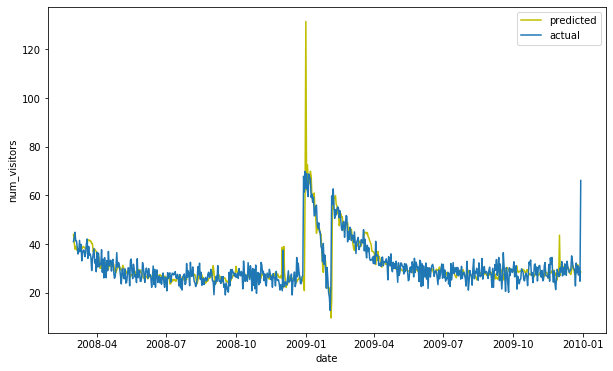

In [35]:
#actual y
OOT_plot=OOT[['date','num_visitors']].iloc[60:]

#predicted y
temp_pred=[]
for v in pred_dict.values():
    temp_pred.append(v[0])
    
OOT_plot['pred_num']=temp_pred
OOT_plot

#visualize
plt.figure(figsize=[10,6])
plt.plot(OOT_plot['date'],OOT_plot['pred_num'],color='y', label='predicted')
plt.plot(OOT_plot['date'],OOT_plot['num_visitors'], label='actual')

plt.xlabel('date')
plt.ylabel('num_visitors')
plt.legend()
plt.show()

## Result: 

### Metric used to evaluate the result : MSE

-  The visitors number at the end and at the beginning of the year is generally very hard to predict:

The above green line shows the predicted num_visitors and the blue line is the actual num_visitors. The overall trend is correctly predicted. However,the prediction on late December and early January are hard. I found that ```the final MSE I got is ```**31.36**```, however, if I remove 2009-01-01, the MSE is would be ```**24.36**```; Either way, the performance is not as good as when we performed on the training set. The MSE of the Linear Regression model on the training set is ```**11.23**.



## Future Work: 

- ***Use a bigger time window to train the data might be a way to improve the model stability:***

I inspected the coefficients of the model everytime I fit a model using the past 60 days data to predict one day, and I realize that the coefficient fluctuation is big even though we only substitute one record at a time. Hence, using more data to fit a model might help us stablize the model prediction.

- ***Try more engineered variables and different dimenionality reduction methods.***

I used linear regression and perform backward elimination to cut down variables and only kept the top7 predictors. If the time allows, trying to build more variables and trying different filter and wrapper methods might improve the performance of the later models.



In [63]:
OOT_plot[OOT_plot['pred_num']==max(OOT_plot['pred_num'])]

,date,num_visitors,pred_num
3288,2009-01-01,62.831707,131.410613


In [175]:
OOT_plot[OOT_plot['date']>'2008-12-26'].head(7)

,date,num_visitors,pred_num
3283,2008-12-27,26.559677,24.702777
3284,2008-12-28,27.072110,25.523229
3285,2008-12-29,67.854310,26.737013
3286,2008-12-30,61.398950,20.902493
3287,2008-12-31,69.849130,60.836727
3288,2009-01-01,62.831707,131.410613
3289,2009-01-02,68.973970,62.367640


In [166]:
OOT_plot[OOT_plot['date']>'2009-12-28']

,date,num_visitors,pred_num
3650,2009-12-29,66.11884,28.521418


In [60]:
temp_SE=[]
for v in SE.values():
    temp_SE.append(v[0])
sum(temp_SE)/len(temp_SE)

31.36109003363726

In [177]:
(sum(temp_SE)-(131.410613-62.831707)**2)/(len(temp_SE)-1)

24.367519287943846